# FEV vs. Semanticity Analysis

For each SimCLR layer, this notebook plots **mean FEV** vs. **silhouette score**.

- **Mean FEV** is taken from the regression: SimCLR features (reduced to N PCs) → Neural data (original dimensionality)

- For each layer, we select the **best FEV** (i.e., highest across PC counts)
  
- Silhouette score is calculated from TSNE-transformed, PCA-reduced SimCLR features. The number of PCs used is normalised across layers

- SimCLR features are extracted from 1,000 images from the STL10 dataset (10 classes, 100 images per class)

In [1]:
from cortexlib.stl10 import STL10FewShotDataset
from cortexlib.simclr import PreTrainedSimCLRModel
from cortexlib.tsne import TSNEVisualizer
from cortexlib.utils.file import read_json_file_as_dataframe, write_json_file
from cortexlib.utils.plotting import simclr_colours
from cortexlib.utils.logging import Logger
import matplotlib.pyplot as plt
from adjustText import adjust_text
import pandas as pd

logger = Logger()

In [2]:
results = read_json_file_as_dataframe('../regressions/results/simclr_feats_pcs_to_neural_data.json')
best_fev_per_layer = results.loc[results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
37,fc,10.0,0.017885,0.112693
2,layer1,20.0,0.026780,0.127222
9,layer2,NaN,0.030758,0.177962
26,layer3,500.0,0.035916,0.157459
27,layer4,NaN,0.022729,0.112540


In [3]:
simclr = PreTrainedSimCLRModel()

logger.progress("Loading STL10 images")
stl10 = STL10FewShotDataset(n_per_class=100, image_size=simclr.get_training_images_resolution())
logger.success("Loaded STL10 images")

19:45:39 | INFO     | ℹ️ Already downloaded pretrained SimCLR model
19:45:39 | INFO     | ⏳ Loading STL10 images...


Files already downloaded and verified
Files already downloaded and verified


19:45:52 | SUCCESS  | ✅ Loaded STL10 images!


In [4]:
logger.progress("SimCLR: extracting features from STL10 images")
simclr_feats, labels = simclr.extract_features(stl10.dataset)
logger.success("SimCLR features extracted")

19:45:52 | INFO     | ⏳ SimCLR: extracting features from STL10 images...


  0%|          | 0/16 [00:00<?, ?it/s]

19:46:04 | SUCCESS  | ✅ SimCLR features extracted!


In [5]:
# Map each label to its corresponding class name
class_labels = [stl10.class_names[label] for label in labels]

tsne_visualiser = TSNEVisualizer()

logger.progress("Computing TSNE features from SimCLR features")
tsne_feats = tsne_visualiser.compute_tsne(simclr_feats, n_pca_components=50)
logger.success("TSNE features computed")

silhouette_scores = tsne_visualiser.compute_silhouette_scores(tsne_feats, class_labels)

19:46:04 | INFO     | ⏳ Computing TSNE features from SimCLR features...
19:46:24 | SUCCESS  | ✅ TSNE features computed!


In [6]:
# json.dump() cannot serialize NumPy float32 types; convert to native Python floats first
silhouette_scores = {k: float(v) for k, v in silhouette_scores.items()}
write_json_file(silhouette_scores, './results/tsne_simclr_feats_vs_neural_data.json')

In [7]:
silhouette_df = pd.DataFrame(list(silhouette_scores.items()), columns=['layer', 'silhouette_score'])
silhouette_df

,layer,silhouette_score
0,layer1,-0.111695
1,layer2,-0.103200
2,layer3,-0.021533
3,layer4,0.079715
4,fc,0.098854


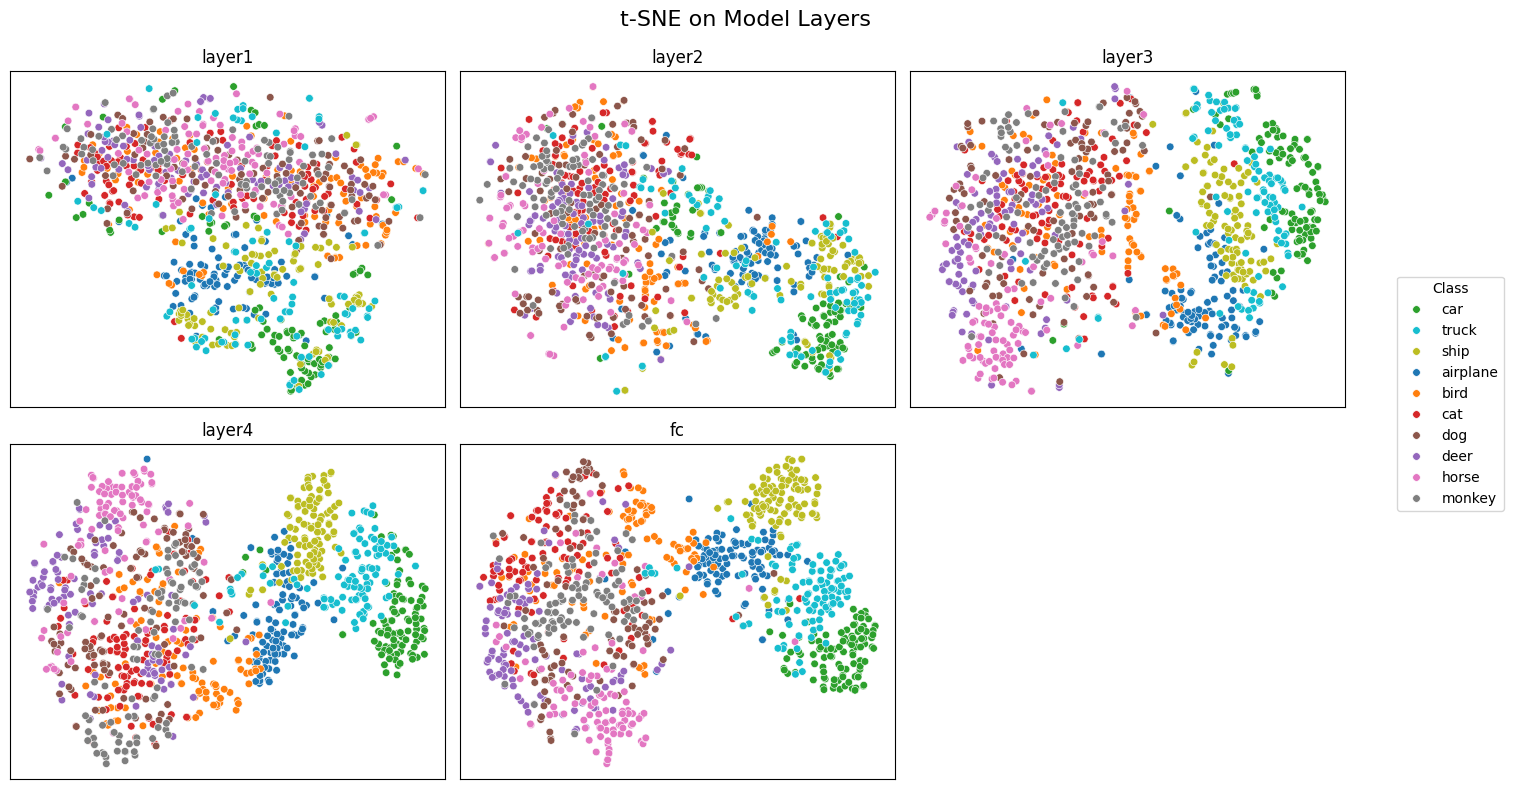

In [8]:
ordered_class_names = ['car', 'truck', 'ship', 'airplane', 'bird', 'cat',
                       'dog', 'deer', 'horse', 'monkey']

tsne_visualiser.plot_clusters_all_layers(tsne_feats, class_labels, custom_legend_order=ordered_class_names)

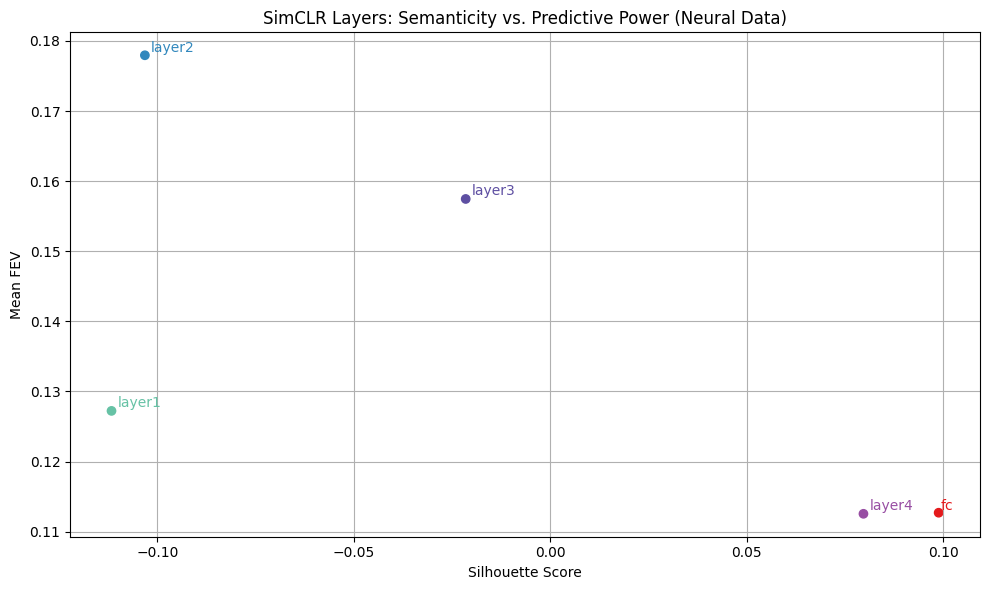

In [9]:
merged_results = pd.merge(best_fev_per_layer, silhouette_df, on='layer')

colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['silhouette_score'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['silhouette_score'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Silhouette Score')
plt.ylabel('Mean FEV')
plt.title('SimCLR Layers: Semanticity vs. Predictive Power (Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()